In [1]:
import numpy as np, pandas as pd                    
import statsmodels.api as sm                         
import statsmodels.formula.api as smf                 
from sklearn.linear_model import LogisticRegression   
from sklearn.metrics import roc_auc_score             
import matplotlib.pyplot as plt, seaborn as sns

SEED = 123
rng = np.random.default_rng(SEED)

In [2]:
df = pd.read_excel("Teste_Matching.xlsx")

In [3]:
df.head()

,ID,Tratamento,Convidado,Outcoming_Y-1,Outcoming_Y,Timing1_Y,Timing2_Y,Position_Y-1,Position_Y,State_Y-1,State_Y,Change_dept
0,1,0,0,51,53,9,7,1,1,7,5,0
1,2,1,1,79,95,3,4,2,2,7,7,0
2,3,0,0,80,71,2,9,2,2,5,5,0
3,4,1,1,65,71,9,7,1,2,2,2,0
4,5,0,0,2,6,4,3,2,3,3,3,1


# Ajustando a base

In [4]:
df = df.copy()                                           # cria uma cópia para não alterar o DataFrame original em memória
df.columns = df.columns.astype(str).str.strip()          # padroniza nomes de colunas (string sem espaços extras)

num_cols = ['Tratamento','Outcoming_Y-1','Outcoming_Y','Timing1_Y','Timing2_Y']  # lista de colunas numéricas esperadas
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')        # converte para número; valores inválidos viram NaN (evita dtype=object)

df['Position_Y-1'] = df['Position_Y-1'].astype('category')  # marca cargo pré como categórico (dummies depois)
df['State_Y-1']    = df['State_Y-1'].astype('category')     # marca diretoria pré como categórico

# proxies PRÉ (como se medidos no ano anterior) e outcome em diferença
df['Timing1_pre'] = df['Timing1_Y'] - 1                  # aproxima tempo de empresa pré (se medido em 2025, subtrai 1 ano)
df['Timing2_pre'] = df['Timing2_Y'] - 1                  # aproxima tempo como líder pré (mesma lógica)
df['dY'] = df['Outcoming_Y'] - df['Outcoming_Y-1']       # constrói variação de desempenho (pós - pré)
df['Tratamento'] = df['Tratamento'].astype(int)          # garante tratamento como inteiro (0/1)

base_cols = ['ID','Tratamento','Outcoming_Y-1','Outcoming_Y','dY','Timing1_pre','Timing2_pre','Position_Y-1','State_Y-1']  # colunas essenciais
df = df.dropna(subset=base_cols).reset_index(drop=True)  # remove linhas com NA nas colunas essenciais e reindexa

In [5]:
df.head()

,ID,Tratamento,Convidado,Outcoming_Y-1,Outcoming_Y,Timing1_Y,Timing2_Y,Position_Y-1,Position_Y,State_Y-1,State_Y,Change_dept,Timing1_pre,Timing2_pre,dY
0,1,0,0,51,53,9,7,1,1,7,5,0,8,6,2
1,2,1,1,79,95,3,4,2,2,7,7,0,2,3,16
2,3,0,0,80,71,2,9,2,2,5,5,0,1,8,-9
3,4,1,1,65,71,9,7,1,2,2,2,0,8,6,6
4,5,0,0,2,6,4,3,2,3,3,3,1,3,2,4


# Calculo inicial - ingenuo

In [6]:
naive_Y  = df.groupby('Tratamento')['Outcoming_Y'].mean().diff().iloc[-1]  # diferença de médias em Y pós entre grupos
naive_dY = df.groupby('Tratamento')['dY'].mean().diff().iloc[-1]           # diferença de médias em ΔY (variação)
print(f"[Naive] diferença de médias em Y pós: {naive_Y:.3f}")              # imprime estimativa ingênua em Y pós
print(f"[Naive] diferença de médias em ΔY:   {naive_dY:.3f}")              # imprime estimativa ingênua em ΔY

[Naive] diferença de médias em Y pós: 4.416
[Naive] diferença de médias em ΔY:   7.042


# Propensity Score - Pareamento dos grupos

AUC do escore de propensão: 0.619


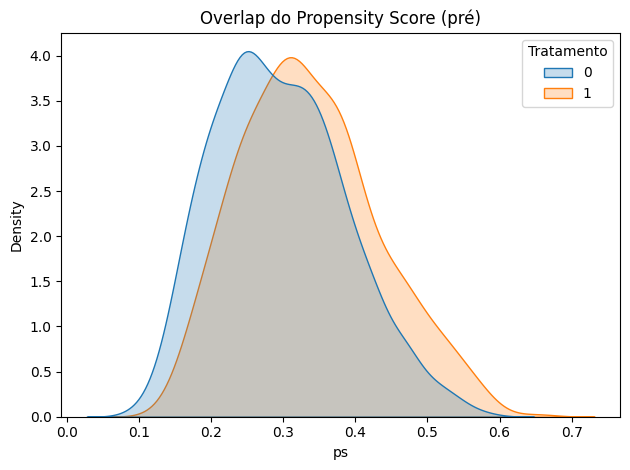


Quantis do PS por grupo:
                0.01      0.05      0.10      0.50      0.90      0.95  \
Tratamento                                                               
0           0.128463  0.161523  0.181026  0.287935  0.418805  0.458567   
1           0.161106  0.190109  0.216438  0.327635  0.471480  0.511836   

                0.99  
Tratamento            
0           0.523862  
1           0.562944  


In [7]:
# ============================================================
# Escore de propensão com VARIÁVEIS PRÉ
# (Y-1, tempos pré, cargo/diretoria de 2024)
# ============================================================
dummies_pre = pd.get_dummies(                              # cria dummies (one-hot) para as categorias pré
    df[['Position_Y-1','State_Y-1']].astype('category'),   # garante dtype categórico
    drop_first=True,                                       # dropa primeira categoria para evitar colinearidade
    dtype=float                                            # gera colunas numéricas (float) diretamente
)
X_ps = pd.concat([                                         # monta matriz X do PS (apenas pré)
    df[['Outcoming_Y-1','Timing1_pre','Timing2_pre']].reset_index(drop=True),  # numéricas pré
    dummies_pre.reset_index(drop=True)                     # dummies pré
], axis=1).astype(float)
y_ps = df['Tratamento'].values                             # vetor de tratamento (0/1) como alvo da logística

ps_model = LogisticRegression(max_iter=2000, solver='lbfgs')  # instancia regressão logística (estimador do PS)
ps_model.fit(X_ps, y_ps)                                   # ajusta modelo de propensão
ps = ps_model.predict_proba(X_ps)[:,1].clip(0.01, 0.99)    # obtém PS estimado e limita entre 0.01 e 0.99 (evita extremos)
logit_ps = np.log(ps/(1-ps))                               # calcula logit(PS) para usar no caliper (distância mais estável)

df['ps'] = ps                                              # salva PS no DataFrame
df['logit_ps'] = logit_ps                                  # salva logit(PS) no DataFrame
print(f"AUC do escore de propensão: {roc_auc_score(y_ps, ps):.3f}")  # imprime a AUC (discriminação do PS)

# Overlap visual e quantis
plt.figure()                                               # abre figura
sns.kdeplot(data=df, x='ps', hue='Tratamento', fill=True, common_norm=False)  # densidades do PS por grupo
plt.title('Overlap do Propensity Score (pré)'); plt.tight_layout(); plt.show()  

print("\nQuantis do PS por grupo:")                        # quantis do PS por grupo para inspecionar suporte
print(df.groupby('Tratamento')['ps'].quantile([0.01,0.05,0.1,0.5,0.9,0.95,0.99]).unstack())  # imprime quantis

In [8]:
# ============================================================
# Common support (trimming 1–99%)
# ============================================================
qt = df.loc[df.Tratamento==1,'ps'].quantile([0.01,0.99])  # quantis extremos do PS nos tratados
qc = df.loc[df.Tratamento==0,'ps'].quantile([0.01,0.99])  # quantis extremos do PS nos controles
lower, upper = max(qt.iloc[0], qc.iloc[0]), min(qt.iloc[1], qc.iloc[1])  # define faixa comum (interseção de quantis)

mask_support = (df['ps'] >= lower) & (df['ps'] <= upper)   # condicao de linhas dentro do suporte comum
df = df.loc[mask_support].reset_index(drop=True)           # filtra DataFrame para suporte comum e reindexa
dummies_pre = pd.get_dummies(df[['Position_Y-1','State_Y-1']], drop_first=True, dtype=float)  # refaz dummies após trimming
X_bal = pd.concat([df[['Outcoming_Y-1','Timing1_pre','Timing2_pre']], dummies_pre], axis=1).astype(float)  # Variaveis X para calculo do SMD

print(f"\nTrimming em suporte comum: PS ∈ [{lower:.3f}, {upper:.3f}] | Nova amostra:", df.shape)  # log do trimming


Trimming em suporte comum: PS ∈ [0.161, 0.524] | Nova amostra: (1888, 17)


In [9]:
df.head()

,ID,Tratamento,Convidado,Outcoming_Y-1,Outcoming_Y,Timing1_Y,Timing2_Y,Position_Y-1,Position_Y,State_Y-1,State_Y,Change_dept,Timing1_pre,Timing2_pre,dY,ps,logit_ps
0,1,0,0,51,53,9,7,1,1,7,5,0,8,6,2,0.399636,-0.406982
1,2,1,1,79,95,3,4,2,2,7,7,0,2,3,16,0.228649,-1.215957
2,3,0,0,80,71,2,9,2,2,5,5,0,1,8,-9,0.308063,-0.809188
3,4,1,1,65,71,9,7,1,2,2,2,0,8,6,6,0.354137,-0.600906
4,5,0,0,2,6,4,3,2,3,3,3,1,3,2,4,0.237093,-1.168682


In [10]:
# ============================================================
# SME - Balanceamento pré
# ============================================================
tmask = df['Tratamento'].values.astype(bool)               # identificacao de quem é tratado
smd_pre = []                                               # lista para armazenar SMDs pré
for c in X_bal.columns:                                    # para cada covariável pré (numérica/dummy)
    m1, m0 = X_bal.loc[tmask,c].mean(), X_bal.loc[~tmask,c].mean()          # média nos tratados vs controles
    v1, v0 = X_bal.loc[tmask,c].var(ddof=1), X_bal.loc[~tmask,c].var(ddof=1)  # variância nos dois grupos
    smd_pre.append((c, (m1-m0)/np.sqrt((v1+v0)/2 + 1e-9)))                  # SMD = diferença padronizada
smd_pre_df = pd.DataFrame(smd_pre, columns=['feature','SMD_pre'])           # DataFrame com SMDs pré
smd_pre_df

,feature,SMD_pre
0,Outcoming_Y-1,-0.087533
1,Timing1_pre,0.178692
2,Timing2_pre,0.242480
3,Position_Y-1_2,0.042412
4,Position_Y-1_3,-0.018870
5,State_Y-1_2,0.006668
6,State_Y-1_3,0.001656
7,State_Y-1_4,-0.009036
8,State_Y-1_5,-0.025990
9,State_Y-1_6,-0.064825


# IPTW

=== IPTW ATE — pesos estabilizados + truncados (1%-99%) ===
count    1888.000000
mean        1.002606
std         0.184244
min         0.625170
50%         0.972751
75%         1.088545
90%         1.238308
95%         1.341203
99%         1.652481
max         1.652822
ESS total: 1826.4 | ESS tratados: 545.4 | ESS controles: 1282.3


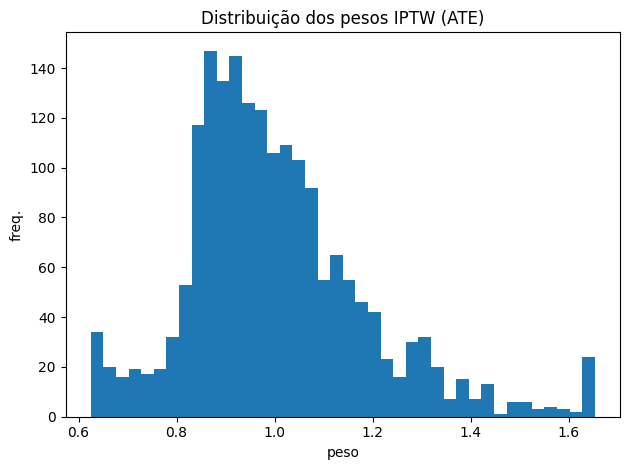

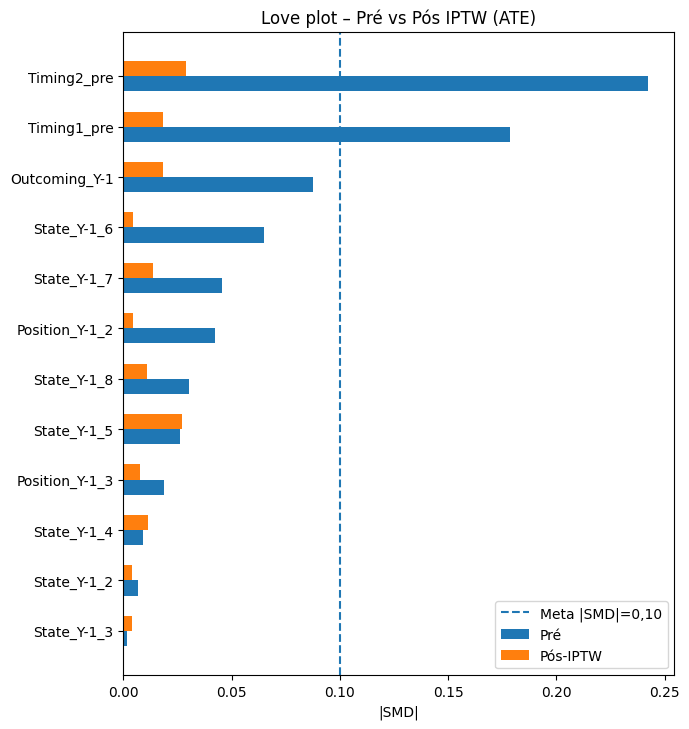

[IPTW-ATE] Outcoming_Y: efeito = 6.769702  |  IC95% = (3.822106, 9.717297)
[IPTW-ATE] dY: efeito = 7.284232  |  IC95% = (6.415330, 8.153134)

=== IPTW ATT — pesos estabilizados + truncados (1%-99%) ===
count    1888.000000
mean        1.381914
std         0.659976
min         0.446245
50%         1.206951
75%         2.227350
90%         2.227350
95%         2.227350
99%         2.227350
max         2.227350
ESS total: 1537.5 | ESS tratados: 585.0 | ESS controles: 1118.4


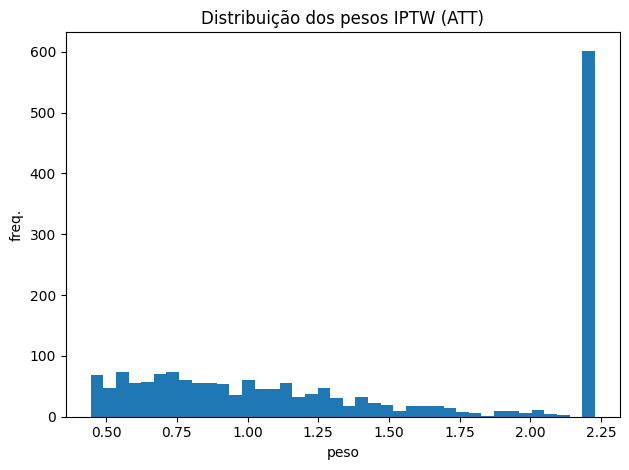

[IPTW-ATT] Outcoming_Y: efeito = 6.595158  |  IC95% = (3.643043, 9.547273)
[IPTW-ATT] dY: efeito = 7.250823  |  IC95% = (6.412818, 8.088829)


In [11]:
# ============================================================
# IPTW — Inverse Probability of Treatment Weighting
#   - ATE: pesos estabilizados + truncagem
#   - ATT: pesos para alvo nos tratados + estabilização + truncagem
#   - Diagnósticos: distribuição de pesos, ESS, balanceamento (SMD) pós-IPTW
#   - Regressão WLS com matriz nomeada (corrige AttributeError do .loc)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ------------------ checagens básicas -----------------------
required_cols = ['Tratamento', 'ps']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Faltam colunas necessárias no df: {missing}. "
                     "Certifique-se de ter 'Tratamento' (0/1) e 'ps' (escore de propensão).")

# outcomes candidatos
y_candidates = ['Outcoming_Y', 'dY']
y_cols = [c for c in y_candidates if c in df.columns]
if not y_cols:
    raise ValueError("Nenhum outcome encontrado. Esperava 'Outcoming_Y' e/ou 'dY' no df.")

# tentativas de uso de X_bal e smd_pre_df (se existirem para Love plot)
have_X_bal = 'X_bal' in globals() or 'X_bal' in locals()
if have_X_bal and not isinstance(X_bal, pd.DataFrame):
    raise ValueError("X_bal existe, mas não é um DataFrame. Converta X_bal para DataFrame de covariáveis pré-tratamento.")

have_smd_pre = 'smd_pre_df' in globals() or 'smd_pre_df' in locals()
if have_smd_pre and not isinstance(smd_pre_df, pd.DataFrame):
    raise ValueError("smd_pre_df existe, mas não é um DataFrame. Esperado DataFrame com colunas ['feature','SMD_pre'].")

# ------------------ utilitários -----------------------------
def wmean(x, w):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    s = w.sum()
    return np.nan if s <= 0 else (w * x).sum() / s

def wvar(x, w, m=None):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    if m is None:
        m = wmean(x, w)
    s = w.sum()
    return 0.0 if s <= 0 else (w * (x - m) ** 2).sum() / s

def smd_weighted(x, t, w):
    x = np.asarray(x, dtype=float)
    t = np.asarray(t, dtype=int)
    w = np.asarray(w, dtype=float)
    m1 = wmean(x[t==1], w[t==1]); v1 = wvar(x[t==1], w[t==1], m1)
    m0 = wmean(x[t==0], w[t==0]); v0 = wvar(x[t==0], w[t==0], m0)
    return (m1 - m0) / np.sqrt((v1 + v0)/2 + 1e-12)

def effective_n(w):
    w = np.asarray(w, dtype=float)
    return (w.sum() ** 2) / (np.square(w).sum() + 1e-12)

# ------------------ vetores básicos -------------------------
t  = df['Tratamento'].astype(int).values
ps = df['ps'].astype(float).values
# não clipar ps globalmente (mantém fidelidade do overlap); apenas proteger divisão
eps = 1e-6
ps_safe = np.clip(ps, eps, 1 - eps)
p_t = t.mean()  # prevalência observada de tratamento

# ============================================================
# 1) Pesos estabilizados para ATE + truncagem (1% e 99%)
#    SW_ATE = P(T=1)/ps para tratados; (1-P(T=1))/(1-ps) para controles
# ============================================================
w_ate = np.where(t==1, p_t / ps_safe, (1 - p_t) / (1 - ps_safe))

# truncagem para reduzir variância de pesos extremos
lo_ate, hi_ate = np.quantile(w_ate, [0.01, 0.99])
w_ate_tr = np.clip(w_ate, lo_ate, hi_ate)
df['w_iptw_ate'] = w_ate_tr

print("=== IPTW ATE — pesos estabilizados + truncados (1%-99%) ===")
print(pd.Series(w_ate_tr).describe(percentiles=[.5, .75, .9, .95, .99]).to_string())
print(f"ESS total: {effective_n(w_ate_tr):.1f} | "
      f"ESS tratados: {effective_n(w_ate_tr[t==1]):.1f} | "
      f"ESS controles: {effective_n(w_ate_tr[t==0]):.1f}")

plt.figure()
plt.hist(w_ate_tr, bins=40)
plt.title("Distribuição dos pesos IPTW (ATE)")
plt.xlabel("peso"); plt.ylabel("freq.")
plt.tight_layout(); plt.show()

# ============================================================
# 2) Balanceamento pós-IPTW (ATE): SMD ponderado + Love plot
#    (requer X_bal e smd_pre_df previamente calculados)
# ============================================================
if have_X_bal:
    smd_post_iptw = []
    for c in X_bal.columns:
        smd_c = smd_weighted(X_bal[c].values, t, w_ate_tr)
        smd_post_iptw.append((c, smd_c))
    smd_post_iptw_df = pd.DataFrame(smd_post_iptw, columns=['feature','SMD_post_IPTW'])

    if have_smd_pre:
        top_k = 50
        love = (smd_pre_df[['feature','SMD_pre']]
                .merge(smd_post_iptw_df, on='feature', how='left'))
        love['|SMD_pre|'] = love['SMD_pre'].abs()
        love = love.sort_values('|SMD_pre|', ascending=False).head(top_k)
        love['|SMD_post_IPTW|'] = love['SMD_post_IPTW'].abs()

        plt.figure(figsize=(7, 0.45 * len(love) + 2))
        y_pos = np.arange(len(love))
        plt.barh(y_pos + 0.15, love['|SMD_pre|'].values,        height=0.3, label='Pré')
        plt.barh(y_pos - 0.15, love['|SMD_post_IPTW|'].values,  height=0.3, label='Pós-IPTW')
        plt.yticks(y_pos, love['feature'].tolist())
        plt.axvline(0.10, ls='--', label='Meta |SMD|=0,10')
        plt.gca().invert_yaxis()
        plt.title('Love plot – Pré vs Pós IPTW (ATE)')
        plt.xlabel('|SMD|'); plt.legend(); plt.tight_layout(); plt.show()
    else:
        print("Aviso: 'smd_pre_df' não encontrado. Calculando apenas SMD pós-IPTW (sem Love plot pré vs pós).")
        display(smd_post_iptw_df.sort_values('SMD_post_IPTW', key=lambda s: s.abs(), ascending=False).head(20))
else:
    print("Aviso: 'X_bal' não encontrado. Pulei a checagem de balanceamento pós-IPTW (ATE).")

# ============================================================
# 3) Estimativa do efeito (ATE) via WLS com matriz nomeada
#    - O coeficiente de 'Tratamento' é o ATE
#    - IC robusto (HC3)
# ============================================================
for y_col in y_cols:
    Y = df[y_col].astype(float).values
    # DataFrame com nomes -> 'const' e 'Tratamento' (evita erro de .loc)
    X_df = pd.DataFrame({
        'const': np.ones(len(df), dtype=float),
        'Tratamento': t.astype(float)
    })
    fit = sm.WLS(Y, X_df, weights=df['w_iptw_ate']).fit(cov_type='HC3')
    tau = float(fit.params['Tratamento'])
    # robustez ao tipo retornado por conf_int (DataFrame ou ndarray)
    ci = fit.conf_int()
    if hasattr(ci, "loc"):
        ci_l, ci_u = ci.loc['Tratamento'].tolist()
    else:
        # fallback posicional
        j = list(fit.params.index).index('Tratamento') if hasattr(fit.params, "index") else 1
        ci_l, ci_u = np.asarray(ci)[j].tolist()
    print(f"[IPTW-ATE] {y_col}: efeito = {tau:.6f}  |  IC95% = ({ci_l:.6f}, {ci_u:.6f})")

# ============================================================
# 4) ATT por IPTW (alvo: efeito médio nos tratados)
#    Pesos (forma padrão): w = 1 (tratados), w = ps/(1-ps) (controles)
#    Aplico estabilização ((1-p_t)/p_t) para controlar variância média
#    + truncagem (1%-99%)
# ============================================================
w_att = np.where(t==1, 1.0, ps_safe / (1 - ps_safe))
w_att *= (1 - p_t) / max(p_t, eps)

lo_att, hi_att = np.quantile(w_att, [0.01, 0.99])
w_att_tr = np.clip(w_att, lo_att, hi_att)
df['w_iptw_att'] = w_att_tr

print("\n=== IPTW ATT — pesos estabilizados + truncados (1%-99%) ===")
print(pd.Series(w_att_tr).describe(percentiles=[.5, .75, .9, .95, .99]).to_string())
print(f"ESS total: {effective_n(w_att_tr):.1f} | "
      f"ESS tratados: {effective_n(w_att_tr[t==1]):.1f} | "
      f"ESS controles: {effective_n(w_att_tr[t==0]):.1f}")

plt.figure()
plt.hist(w_att_tr, bins=40)
plt.title("Distribuição dos pesos IPTW (ATT)")
plt.xlabel("peso"); plt.ylabel("freq.")
plt.tight_layout(); plt.show()

# ATT via WLS (coef. de 'Tratamento')
for y_col in y_cols:
    Y = df[y_col].astype(float).values
    X_df = pd.DataFrame({
        'const': np.ones(len(df), dtype=float),
        'Tratamento': t.astype(float)
    })
    fit = sm.WLS(Y, X_df, weights=df['w_iptw_att']).fit(cov_type='HC3')
    tau = float(fit.params['Tratamento'])
    ci = fit.conf_int()
    if hasattr(ci, "loc"):
        ci_l, ci_u = ci.loc['Tratamento'].tolist()
    else:
        j = list(fit.params.index).index('Tratamento') if hasattr(fit.params, "index") else 1
        ci_l, ci_u = np.asarray(ci)[j].tolist()
    print(f"[IPTW-ATT] {y_col}: efeito = {tau:.6f}  |  IC95% = ({ci_l:.6f}, {ci_u:.6f})")

# Matching - construcao grupo controle

In [12]:
# ============================================================
# Matching k:1 SEM REUSO de controles + caliper
#     - EXATO por cargo/diretoria (pré)
#     - cada controle escolhido para um tratado é usado no MÁXIMO 1x
# ============================================================

df['strata'] = df['Position_Y-1'].astype(str) + '||' + df['State_Y-1'].astype(str) 
# Cria uma chave de estrato (string) combinando cargo e diretoria de 2024 (pré),
# para exigir matching EXATO dentro do mesmo estrato.

treated_idx  = df.index[df.Tratamento==1] # Índices (linhas) dos colaboradores tratados (Treinamento==1).

control_idx  = df.index[df.Tratamento==0] # Índices (linhas) dos colaboradores controle (Treinamento==0).

# Definicao do caliper (0.25*DP do logit-PS nos CONTROLES)
caliper_factor = 0.25
# Fator do caliper: multiplicador do desvio padrão do logit(PS).

caliper = caliper_factor * np.std(df.loc[control_idx, 'logit_ps'])
# Largura do caliper: 0.25 × DP do logit(PS) entre controles (regra prática).
# Só aceitaremos matches cuja distância no logit(PS) seja <= caliper.

k = 2  # número de vizinhos por tratado (pega até k se houver)
# Para cada tratado, vamos casar com até 2 controles (desde que dentro do caliper).

# mapa de controles por estrato (exato)
strata_to_ctrl = {}
# Dicionário onde a chave é o estrato (cargo||diretoria) e o valor é a lista
# de índices de controles disponíveis naquele estrato.

for i in control_idx:
    strata_to_ctrl.setdefault(df.at[i, 'strata'], []).append(i)
# Preenche o dicionário: para cada controle, adiciona seu índice na lista do estrato correspondente.

pairs = []           # (t_idx, c_idx, w)
# Lista onde vamos guardar os matches como tuplas: (índice_tratado, índice_controle, peso_dentro_do_tratado).

used_controls = set()  # impede reuso global
# Conjunto de controles já utilizados; garante matching SEM REPOSIÇÃO (sem reuso).

dists = []           # para diagnóstico da qualidade dos matches
# Lista para registrar as distâncias (em logit-PS) dos matches aceitos, útil para diagnóstico.

for ti in treated_idx:
    # Loop sobre cada tratado (na ordem dos índices).
    key = df.at[ti, 'strata']
    # Estrato do tratado atual (cargo||diretoria).

    # pool de controles do mesmo estrato que AINDA NÃO foram usados
    pool_all = strata_to_ctrl.get(key, [])
    # Lista de controles candidatos no mesmo estrato (pode estar vazia).

    pool = [j for j in pool_all if j not in used_controls]
    # Filtra os candidatos removendo controles já usados (sem reposição).

    if not pool:
        continue
    # Se não há controles elegíveis nesse estrato, pula este tratado.

    cand = np.array(pool)
    # Converte a lista de candidatos para array NumPy (facilita indexações).

    d = np.abs(df.loc[cand, 'logit_ps'].values - df.at[ti, 'logit_ps'])
    # Calcula a distância absoluta no logit(PS) entre cada candidato e o tratado.

    order = np.argsort(d)
    # Ordena os índices dos candidatos por distância crescente (mais próximos primeiro).

    # aplica caliper e seleciona até k
    chosen = [cand[j] for j in order if d[j] <= caliper][:k]
    # Seleciona, na ordem de proximidade, apenas aqueles cuja distância <= caliper,
    # e limita a, no máximo, k candidatos.

    if chosen:
        w = 1.0 / len(chosen)  # peso igual DENTRO do tratado
        # Peso que cada controle escolhido terá na média do tratado (soma dos pesos = 1 por tratado).

        for cj in chosen:
            pairs.append((ti, cj, w))
            # Registra o par (tratado, controle, peso) na lista de matches.

            used_controls.add(cj)  # marca controle como usado (sem reposição)
            # Garante que este controle não poderá ser usado por outro tratado.

            dists.append(abs(df.at[cj, 'logit_ps'] - df.at[ti, 'logit_ps']))
            # Armazena a distância do match para diagnóstico (mediana, P90 etc.).

pairs = pd.DataFrame(pairs, columns=['t_idx','c_idx','w'])
# Converte a lista de matches em DataFrame com colunas: índice do tratado, índice do controle, peso interno.

# logs úteis
n_trat_total    = int((df.Tratamento==1).sum())
# Número total de tratados na amostra (após eventuais trims).

n_trat_pareados = pairs['t_idx'].nunique()
# Quantos tratados efetivamente conseguiram pelo menos um controle dentro do caliper (cobertura).

n_ctrl_unicos   = pairs['c_idx'].nunique()
# Quantos controles distintos foram utilizados (deve ser igual ao número de links se k=1 e sem reuso; aqui pode ser menor que links).

print(f"\nPareamento (sem reuso): {n_trat_pareados} tratados pareados de {n_trat_total} "
      f"({n_trat_pareados/max(1,n_trat_total):.1%}). Links: {len(pairs)}")
# Loga a cobertura do pareamento (proporção de tratados pareados) e o total de links (pares tratados-controles).

print(f"Controles únicos usados: {n_ctrl_unicos} (reuso proibido)")
# Loga o número de controles únicos usados, reforçando que não há reuso.

if dists:
    print("Distância (logit-PS) dos matches: mediana={:.4f} | P90={:.4f} | máx={:.4f}"
          .format(np.median(dists), np.quantile(dists, 0.90), np.max(dists)))
# Se houve matches, imprime estatísticas das distâncias (mediana, percentil 90, máximo


Pareamento (sem reuso): 469 tratados pareados de 585 (80.2%). Links: 885
Controles únicos usados: 885 (reuso proibido)
Distância (logit-PS) dos matches: mediana=0.0192 | P90=0.0705 | máx=0.0994


In [ ]:
def nearest_neighbor_match(
    df,
    k=2,
    with_replacement=False,                 # << escolha: True = com reposição | False = sem reposição
    caliper_factor=0.25,                    # largura = fator * DP(score) nos CONTROLES
    strata_cols=('Position_Y-1', 'State_Y-1'),  # colunas para matching EXATO por estrato
    treatment_col='Tratamento',
    ps_col='ps',                            # caso queira usar PS direto
    logit_ps_col='logit_ps',                # coluna com logit(PS); será criada se não existir e houver 'ps'
    use_logit_score=True,                   # True = usar logit(PS) no cálculo de distância/caliper
    verbose=True
):
    """
    Matching k:1 com/sem reposição + caliper + exato por estrato.
    Retorna um DataFrame com colunas: ['t_idx', 'c_idx', 'w'].
    'w' é o peso DENTRO do tratado (soma=1 por tratado emparelhado).
    """
    df = df.copy()

    # 1) Score a ser usado (logit(PS) por padrão)
    if use_logit_score:
        if logit_ps_col not in df.columns:
            if ps_col not in df.columns:
                raise ValueError("Informe 'logit_ps' ou 'ps' na base.")
            p = np.clip(df[ps_col].to_numpy(), 1e-6, 1-1e-6)
            df[logit_ps_col] = np.log(p/(1-p))
        score_col = logit_ps_col
    else:
        if ps_col not in df.columns:
            raise ValueError("use_logit_score=False exige coluna 'ps'.")
        score_col = ps_col

    # 2) Estratos para matching exato (ou 'all' se não quiser estratificar)
    if strata_cols and len(strata_cols) > 0:
        df['strata'] = df.loc[:, list(strata_cols)].astype(str).agg('||'.join, axis=1)
    else:
        df['strata'] = 'all'

    treated_idx = df.index[df[treatment_col] == 1]
    control_idx = df.index[df[treatment_col] == 0]

    # 3) Caliper (DP do score calculada nos controles)
    caliper = caliper_factor * np.std(df.loc[control_idx, score_col])
    if np.isnan(caliper) or caliper <= 0:
        raise ValueError("Caliper inválido (verifique score nos controles).")

    # 4) Índices de controles por estrato (para matching exato)
    strata_to_ctrl = {}
    for i in control_idx:
        strata_to_ctrl.setdefault(df.at[i, 'strata'], []).append(i)

    pairs = []            # (t_idx, c_idx, w)
    dists = []            # diagnósticos de distância
    used_controls = set() # impede reuso quando with_replacement=False

    # 5) Loop nos tratados
    for ti in treated_idx:
        key = df.at[ti, 'strata']
        pool_all = strata_to_ctrl.get(key, [])
        if not pool_all:
            continue

        # pool elegível (considera reuso ou não)
        if with_replacement:
            pool = pool_all
        else:
            pool = [j for j in pool_all if j not in used_controls]
            if not pool:
                continue

        cand = np.array(pool)
        d = np.abs(df.loc[cand, score_col].values - df.at[ti, score_col])

        # aplica caliper
        in_caliper = d <= caliper
        if not np.any(in_caliper):
            continue

        cand = cand[in_caliper]
        d = d[in_caliper]

        # escolhe até k mais próximos
        order = np.argsort(d)
        chosen = cand[order][:k]

        if len(chosen) == 0:
            continue

        w = 1.0 / len(chosen)  # pesos iguais dentro do tratado
        for cj in chosen:
            pairs.append((ti, cj, w))
            dists.append(abs(df.at[cj, score_col] - df.at[ti, score_col]))
            if not with_replacement:
                used_controls.add(cj)

    pairs = pd.DataFrame(pairs, columns=['t_idx', 'c_idx', 'w'])

    # 6) Logs úteis
    if verbose:
        n_trat_total    = int((df[treatment_col] == 1).sum())
        n_trat_pareados = pairs['t_idx'].nunique() if not pairs.empty else 0
        n_ctrl_unicos   = pairs['c_idx'].nunique() if not pairs.empty else 0
        tag = "com REUSO" if with_replacement else "sem reuso"

        print(f"\nPareamento ({tag}): {n_trat_pareados} tratados pareados de {n_trat_total} "
              f"({n_trat_pareados/max(1,n_trat_total):.1%}). Links: {len(pairs)}")
        print(f"Controles únicos usados: {n_ctrl_unicos}" + ("" if with_replacement else " (reuso proibido)"))

        if len(dists) > 0:
            dists = np.array(dists)
            print("Distância no score: mediana={:.4f} | P90={:.4f} | máx={:.4f}"
                  .format(np.median(dists), np.quantile(dists, 0.90), np.max(dists)))

    return pairs

# -------------------------
# EXEMPLOS DE USO:
# -------------------------
# 1) Sem reposição (equivalente ao seu código original, mas parametrizado)
# pairs_no_reuse = nearest_neighbor_match(df, k=2, with_replacement=False,
#                                         caliper_factor=0.25,
#                                         strata_cols=('Position_Y-1','State_Y-1'),
#                                         treatment_col='Tratamento',
#                                         logit_ps_col='logit_ps', use_logit_score=True)

# 2) Com reposição (permite que um mesmo controle sirva a múltiplos tratados)
# pairs_with_reuse = nearest_neighbor_match(df, k=2, with_replacement=True,
#                                           caliper_factor=0.25,
#                                           strata_cols=('Position_Y-1','State_Y-1'),
#                                           treatment_col='Tratamento',
#                                           logit_ps_col='logit_ps', use_logit_score=True)

In [13]:
# tabela final com index do tratado, controle e respectivo peso
pairs

,t_idx,c_idx,w
0,1,1239,0.5
1,1,1362,0.5
2,3,1368,0.5
3,3,129,0.5
4,5,855,0.5
...,...,...,...
880,1876,1875,0.5
881,1877,1522,0.5
882,1877,56,0.5
883,1879,1638,0.5


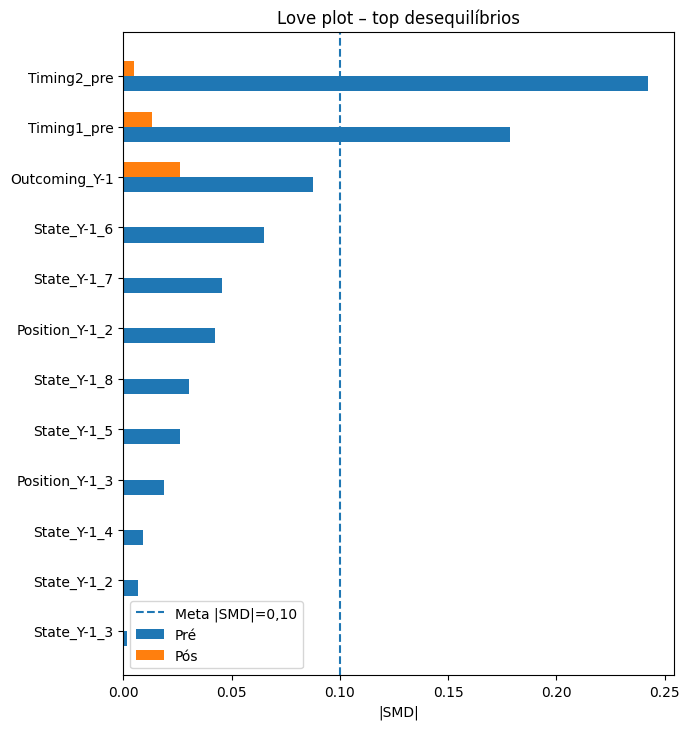

In [14]:
# ============================================================
#SMD pós-matching (ponderado) + Love plot (pré vs pós)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- helpers para média/variância ponderadas ---
def wmean(x, w):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    s = w.sum()
    return np.nan if s <= 0 else (w * x).sum() / s

def wvar(x, w, m=None):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    if m is None:
        m = wmean(x, w)
    s = w.sum()
    return 0.0 if s <= 0 else (w * (x - m) ** 2).sum() / s

# ---------- Top-k variáveis mais desequilibradas no PRÉ ----------
top_k = 50
top_feats = (smd_pre_df[['feature','SMD_pre']]
             .assign(abs_pre=lambda d: d['SMD_pre'].abs())
             .sort_values('abs_pre', ascending=False)['feature']
             .head(top_k)
             .tolist())

# ---------- SMD PÓS: ponderado pelos pesos do matching ----------
if len(pairs) > 0:
    # índices usados (tratados e controles pareados)
    used = np.unique(pairs[['t_idx', 'c_idx']].values.ravel()).astype(int)

    # pesos por unidade a partir do objeto "pairs"
    w_t = pd.Series(1.0, index=pairs['t_idx'].unique())      # tratado com peso 1
    w_c = pairs.groupby('c_idx')['w'].sum()                  # controle com soma dos pesos dos pares
    weights = pd.Series(0.0, index=df.index)
    weights.loc[w_t.index] = 1.0
    weights.loc[w_c.index] = w_c.values
    w_used = weights.loc[used].fillna(0.0)

    # covariáveis pré nos pareados (numéricas)
    Xm = X_bal.loc[used].apply(pd.to_numeric, errors='coerce')
    tm = df.loc[used, 'Tratamento'].astype(bool).values

    smd_post = []
    for c in Xm.columns:
        x = Xm[c].values
        w1 = np.where(tm,  w_used.values, 0.0)   # pesos no grupo tratado
        w0 = np.where(~tm, w_used.values, 0.0)   # pesos no grupo controle
        m1, m0 = wmean(x, w1), wmean(x, w0)
        v1, v0 = wvar(x, w1, m1), wvar(x, w0, m0)
        denom = np.sqrt(0.5 * (v1 + v0) + 1e-9)
        smd_post.append((c, (m1 - m0) / denom))
    smd_post_df = pd.DataFrame(smd_post, columns=['feature', 'SMD_post'])
else:
    smd_post_df = pd.DataFrame({'feature': X_bal.columns, 'SMD_post': np.nan})

# ---------- Love plot (pré vs pós) ----------
love = (smd_pre_df.merge(smd_post_df, on='feature', how='left')
                  .set_index('feature')
                  .reindex(top_feats)
                  .reset_index())

if love['SMD_post'].isna().all():
    love['SMD_post'] = 0.0

love['|SMD_pre|']  = love['SMD_pre'].abs()
love['|SMD_post|'] = love['SMD_post'].abs()

plt.figure(figsize=(7, 0.45 * len(love) + 2))
y = np.arange(len(love))
plt.barh(y + 0.15, love['|SMD_pre|'].values,  height=0.3, label='Pré')
plt.barh(y - 0.15, love['|SMD_post|'].values, height=0.3, label='Pós')
plt.yticks(y, love['feature'].tolist())
plt.axvline(0.1, ls='--', label='Meta |SMD|=0,10')
plt.gca().invert_yaxis()
plt.title('Love plot – top desequilíbrios')
plt.xlabel('|SMD|')
plt.legend()
plt.tight_layout()
plt.show()

# Teste t

In [15]:
# ============================================================
# Potência para detectar efeitos pequenos (Cohen's d baixo)
# - Usa TTestIndPower (assume variâncias iguais como aproximação)
# - Calcula power para d em {0.10, 0.15, 0.20, 0.25, 0.30}
# - Alfas usuais: 0.10, 0.05, 0.01 (bicaudal)
# - Também calcula n_t necessário p/ 80% de potência (α=0.05) mantendo o mesmo ratio n_c/n_t
# ============================================================
import numpy as np, pandas as pd
from statsmodels.stats.power import TTestIndPower

analysis = TTestIndPower()

# 1) Tamanhos amostrais
if 'pairs' in globals() and len(pairs):
    n_t = int(pairs['t_idx'].nunique())
    n_c = int(pairs['c_idx'].nunique())
    base_desc = "conjunto pareado (pesos iguais)"
else:
    n_t = int((df.Tratamento==1).sum())
    n_c = int((df.Tratamento==0).sum())
    base_desc = "grupos originais (sem pareamento)"

ratio = n_c / max(1, n_t)
print(f"Base para o cálculo de potência: {base_desc} | n_t={n_t}, n_c={n_c}, ratio={ratio:.2f}")

# 2) Grade de efeitos pequenos (Cohen's d) e alfas usuais
d_grid   = np.array([0.10, 0.15, 0.20, 0.25, 0.30], dtype=float)
alphas   = [0.10, 0.05, 0.01]
alt      = 'two-sided'     # use 'larger' se o teste for unilateral (poder ↑)

# 3) Potência para cada (d, alpha)
rows = []
for d in d_grid:
    for a in alphas:
        pow_ = analysis.power(effect_size=d, nobs1=n_t, alpha=a, ratio=ratio, alternative=alt)
        rows.append({'d': d, 'alpha': a, 'power': pow_})

df_power = pd.DataFrame(rows)

# 4) n_t necessário para 80% de potência com α=0.05 (mantendo o mesmo ratio)
target_power = 0.80
alpha_plan   = 0.05
req_rows = []
for d in d_grid:
    try:
        n_t_needed = analysis.solve_power(effect_size=d, alpha=alpha_plan, power=target_power,
                                          ratio=ratio, alternative=alt)
        # arredonda pra cima e calcula n_c correspondente mantendo ratio
        n_t_needed_ceil = int(np.ceil(n_t_needed))
        n_c_needed = int(np.ceil(n_t_needed_ceil * ratio))
    except Exception as e:
        n_t_needed_ceil, n_c_needed = np.nan, np.nan
    req_rows.append({'d': d, 'n_t_needed_80%_alpha5%': n_t_needed_ceil, 'n_c_needed_80%_alpha5%': n_c_needed})

df_needed = pd.DataFrame(req_rows)

# 5) Exibição compacta
print("\nPotência por d (linhas) e α (colunas) — teste bicaudal:")
print(df_power.pivot(index='d', columns='alpha', values='power').round(3))

print("\nTamanho necessário para 80% de potência (α=0.05), mantendo o ratio atual:")
print(df_needed)

Base para o cálculo de potência: conjunto pareado (pesos iguais) | n_t=469, n_c=885, ratio=1.89

Potência por d (linhas) e α (colunas) — teste bicaudal:
alpha   0.01   0.05   0.10
d                         
0.10   0.204  0.417  0.542
0.15   0.519  0.747  0.836
0.20   0.822  0.938  0.968
0.25   0.964  0.992  0.997
0.30   0.996  0.999  1.000

Tamanho necessário para 80% de potência (α=0.05), mantendo o ratio atual:
      d  n_t_needed_80%_alpha5%  n_c_needed_80%_alpha5%
0  0.10                    1202                    2269
1  0.15                     535                    1010
2  0.20                     301                     568
3  0.25                     193                     365
4  0.30                     135                     255


In [16]:
# ============================================================
# T-test (Welch) no CONJUNTO PAREADO — pesos iguais (não ponderado)
# - Compara médias entre: Tratados pareados vs Controles selecionados
# - Sem pesos: cada observação do matched sample tem peso igual
# - Rodamos para ΔY e para Y pós
# ============================================================
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

if 'pairs' in globals() and len(pairs):
    # 1) Seleciona os índices usados no matching (sem reuso, então cada controle aparece 1x)
    T_used = pairs['t_idx'].unique()   # tratados que foram pareados
    C_used = pairs['c_idx'].unique()   # controles que foram selecionados

    # 2) Extrai amostras (pesos iguais = não usar pesos)
    dy_t = df.loc[T_used, 'dY'].astype(float).dropna()
    dy_c = df.loc[C_used, 'dY'].astype(float).dropna()

    ypost_t = df.loc[T_used, 'Outcoming_Y'].astype(float).dropna()
    ypost_c = df.loc[C_used, 'Outcoming_Y'].astype(float).dropna()

    # ---------- ΔY ----------
    cm = CompareMeans(DescrStatsW(dy_t.values), DescrStatsW(dy_c.values))
    tstat, pval, dfree = cm.ttest_ind(usevar='unequal')           # Welch
    ci_low, ci_high    = cm.tconfint_diff(usevar='unequal')
    diff = dy_t.mean() - dy_c.mean()

    print("\n[T-test Welch | ΔY] Tratados pareados vs Controles selecionados (pesos iguais)")
    print(f"n_t={len(dy_t)}, n_c={len(dy_c)} | média_t={dy_t.mean():.3f}, média_c={dy_c.mean():.3f} | Δ={diff:.3f}")
    print(f"t={tstat:.3f}, df≈{dfree:.1f}, p-valor={pval:.4f}, IC95% Δ: [{ci_low:.3f}, {ci_high:.3f}]")

    # ---------- Y pós ----------
    cm = CompareMeans(DescrStatsW(ypost_t.values), DescrStatsW(ypost_c.values))
    tstat, pval, dfree = cm.ttest_ind(usevar='unequal')           # Welch
    ci_low, ci_high    = cm.tconfint_diff(usevar='unequal')
    diff = ypost_t.mean() - ypost_c.mean()

    print("\n[T-test Welch | Y pós] Tratados pareados vs Controles selecionados (pesos iguais)")
    print(f"n_t={len(ypost_t)}, n_c={len(ypost_c)} | média_t={ypost_t.mean():.3f}, média_c={ypost_c.mean():.3f} | Δ={diff:.3f}")
    print(f"t={tstat:.3f}, df≈{dfree:.1f}, p-valor={pval:.4f}, IC95% Δ: [{ci_low:.3f}, {ci_high:.3f}]")

else:
    print("\n[Info] 'pairs' não encontrado ou vazio — gere a seção de matching antes do t-test igual-peso no pareado.")


[T-test Welch | ΔY] Tratados pareados vs Controles selecionados (pesos iguais)
n_t=469, n_c=885 | média_t=7.580, média_c=0.146 | Δ=7.434
t=15.466, df≈660.0, p-valor=0.0000, IC95% Δ: [6.490, 8.378]

[T-test Welch | Y pós] Tratados pareados vs Controles selecionados (pesos iguais)
n_t=469, n_c=885 | média_t=55.898, média_c=49.641 | Δ=6.257
t=3.707, df≈947.3, p-valor=0.0002, IC95% Δ: [2.944, 9.570]


# WLS

In [17]:
# ===============================================================================================
# Regressão Ponderada (WLS) na Amostra Pareada — ANCOVA para estimar ATT no conjunto pareado
# ===============================================================================================
# Objetivo: estimar o efeito causal do treinamento (Tratamento) sobre o outcome pós (Outcoming_Y),
# controlando o outcome pré (Outcoming_Y-1) e outras covariáveis (ANCOVA), mas
#   1) USANDO APENAS as unidades que foram pareadas (matched) e
#   2) LEVANDO os PESOS do matching para a regressão (tratado=1; controle=soma dos pesos recebidos),
#   3) CALCULANDO ERROS-PADRÃO CLUSTERIZADOS por matched set (um set por tratado).
#
# Por que isso funciona?
# - Matching cria pares/grupos comparáveis (tratado x controles parecidos).
# - Pesos do matching dizem quanto cada controle “representa” um contrafactual de um tratado.
# - ANCOVA reduz variância e corrige pequeno desequilíbrio residual.
# - Cluster por matched set corrige a dependência estatística dentro de cada conjunto emparelhado.

import numpy as np
import pandas as pd
import statsmodels.api as sm

# ----------------------------- #
# ETAPA 1 — AMOSTRA E PESOS     #
# ----------------------------- #

# Une os índices dos tratados e dos controles usados no matching.
# Resultado: somente as unidades efetivamente pareadas entram na análise.
used_idx = np.union1d(pairs['t_idx'].unique(), pairs['c_idx'].unique()).astype(int)
print(f"Total de indivíduos na amostra pareada para a regressão: {len(used_idx)}")

# Garante a suposição “sem reposição”: cada controle só aparece em um set.
assert not pairs.duplicated(subset=['c_idx']).any(), "Encontrado controle reaproveitado; esperado 'sem reposição'."

# Constrói os pesos por unidade:
# - Tratados: peso 1 (cada tratado contribui igualmente para o ATT).
# - Controles: soma dos pesos 'w' vindos dos sets em que aparecem (aqui, sem reposição → um set só).
w_t = pd.Series(1.0, index=pairs['t_idx'].unique())          # peso 1 para cada tratado
w_c = pairs.groupby('c_idx')['w'].sum()                       # peso agregado por controle
weights = pd.Series(0.0, index=df.index)                      # inicia todo mundo com peso 0
weights.loc[w_t.index] = 1.0                                  # seta peso 1 para tratados
weights.loc[w_c.index] = w_c.values                           # seta pesos para controles

# Mantém apenas os pesos referentes às unidades pareadas.
weights_matched = weights.loc[used_idx]

# Normaliza os pesos para que a média seja ≈ 1 (boa prática numérica: não altera coeficientes,
# ajuda a estabilizar a matriz de covariância robusta).
weights_matched = weights_matched * (len(weights_matched) / weights_matched.sum())

# ---------------------------------------------- #
# ETAPA 2 — CLUSTERS: ID DO MATCHED SET (por t)  #
# ---------------------------------------------- #

# Para clusterizar corretamente os erros:
# - Cada tratado define um "matched set" com seu próprio t_idx.
# - Cada controle herda o t_idx do tratado com quem foi pareado.
set_id = pd.Series(pd.NA, index=df.index, dtype='Int64')
set_id.loc[pairs['t_idx'].unique()] = pairs['t_idx'].unique()   # tratado → seu próprio set

# Como não há reposição, cada controle mapeia para um único set (t_idx do tratado correspondente).
ctrl_map = pairs.set_index('c_idx')['t_idx']
set_id.loc[ctrl_map.index] = ctrl_map.values

# -------------------------------------------------------------- #
# ETAPA 3 — MATRIZ DE DESIGN (ANCOVA) SOMENTE NA AMOSTRA PAREADA #
# -------------------------------------------------------------- #

# Recorta df e dummies para conter só as unidades pareadas (mesmo índice → sem desalinhamento).
df_matched = df.loc[used_idx]
dummies_pre_matched = dummies_pre.loc[used_idx]

# Monta X com:
# - Intercepto ('const')
# - Tratamento (indicador)
# - Outcome pré (Outcoming_Y-1) → ANCOVA
# - Controles de tempo/nível (Timing1_pre, Timing2_pre)
# - Dummies pré (estratificadores/covariáveis discretas já transformadas)
X_wls = pd.concat([
    df_matched[['Tratamento', 'Outcoming_Y-1', 'Timing1_pre', 'Timing2_pre']],
    dummies_pre_matched
], axis=1)

# Converte tudo para numérico (se alguma dummy/covariável veio como objeto) e adiciona intercepto
X_wls = X_wls.apply(pd.to_numeric, errors='coerce')
X_wls = sm.add_constant(X_wls, has_constant='add')

# Variável resposta: outcome pós-intervenção
y_wls = df_matched['Outcoming_Y']

# Vetor de clusters (grupo) alinhado a X: para cada linha de X, pega o set_id correspondente
g_wls = set_id.loc[X_wls.index]

# ----------------------------------------------------------------- #
# ETAPA 4 — MÁSCARA ÚNICA (ALINHAMENTO + LIMPEZA DE OBSERVAÇÕES)    #
# ----------------------------------------------------------------- #

# Cria uma máscara booleana que retém apenas as linhas com:
# - Todas as covariáveis de X válidas (sem NA)
# - Outcome válido (sem NA)
# - Peso válido (sem NA)
# - Cluster válido (sem NA)
mask = (
    X_wls.notna().all(axis=1) &
    y_wls.notna() &
    weights_matched.notna() &
    g_wls.notna()
)

# Aplica a máscara para garantir que X, y, pesos e clusters tenham o MESMO índice/mesmas linhas
X_wls = X_wls.loc[mask]
y_wls = y_wls.loc[mask]
weights_matched = weights_matched.loc[mask]
g_wls = g_wls.loc[mask].astype('int64')   # clusters precisam ser inteiros para o robust cluster

# ----------------------------------------------- #
# ETAPA 5 — AJUSTE WLS COM CLUSTER POR MATCHED SET #
# ----------------------------------------------- #

# Ajusta a regressão ponderada:
# - endog = y pós
# - exog  = X (const + Tratamento + Y_pre + covariáveis)
# - weights = pesos do matching (tratado=1; controle=soma dos pesos)
# - cov_type='cluster' com groups = matched set (corrige a dependência dentro do par/grupo emparelhado)
wls_ancova_model = sm.WLS(
    endog=y_wls,
    exog=X_wls,
    weights=weights_matched
).fit(
    cov_type='cluster',
    cov_kwds={'groups': g_wls}
)

# -------------------------------------- #
# ETAPA 6 — RESULTADOS E INTERPRETAÇÃO   #
# -------------------------------------- #

# Coeficiente do Tratamento na ANCOVA ponderada:
# → Interpretação: ATT ajustado na amostra pareada (sob ignorabilidade + overlap garantidos pelo matching)
wls_eff = wls_ancova_model.params['Tratamento']

# Intervalo de confiança (IC95%) do coeficiente de Tratamento
wls_ci = wls_ancova_model.conf_int().loc['Tratamento']

print(f"\nANCOVA Ponderada (WLS) coef Tratamento: {wls_eff:.3f} | IC95% [{wls_ci[0]:.3f}, {wls_ci[1]:.3f}]")

# Sumário completo com EPs clusterizados por matched set (útil para auditoria e documentação)
print("\nSumário Completo do Modelo Final:")
print(wls_ancova_model.summary())

Total de indivíduos na amostra pareada para a regressão: 1354

ANCOVA Ponderada (WLS) coef Tratamento: 7.347 | IC95% [6.395, 8.300]

Sumário Completo do Modelo Final:
                            WLS Regression Results                            
Dep. Variable:            Outcoming_Y   R-squared:                       0.930
Model:                            WLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     1105.
Date:                Tue, 30 Sep 2025   Prob (F-statistic):               0.00
Time:                        21:50:03   Log-Likelihood:                -4749.1
No. Observations:                1354   AIC:                             9526.
Df Residuals:                    1340   BIC:                             9599.
Df Model:                          13                                         
Covariance Type:              cluster                                         
                     coef    std err       

# Analise de variabilidade do resultado pelas variaveis pós

In [18]:
# Adicionamos a coluna dY para facilitar
df_matched['dY'] = df_matched['Outcoming_Y'] - df_matched['Outcoming_Y-1']

# 1. Análise por Cargo Pós-Tratamento (Position_Y)
print("--- Análise por Cargo Pós-Tratamento ---")
# Agrupa por cargo final e status de tratamento, e calcula a média de dY
efeito_por_cargo = df_matched.groupby(['Position_Y', 'Tratamento'])['dY'].mean().unstack()

# Calcula a diferença (o efeito do tratamento) para cada cargo
efeito_por_cargo['Efeito_Tratamento (ATT)'] = efeito_por_cargo[1] - efeito_por_cargo[0]
print(efeito_por_cargo)


# 2. Análise por Departamento Pós-Tratamento (State_Y)
print("\n--- Análise por Departamento Pós-Tratamento ---")
# Agrupa por depto final e status de tratamento, e calcula a média de dY
efeito_por_depto = df_matched.groupby(['State_Y', 'Tratamento'])['dY'].mean().unstack()

# Calcula a diferença (o efeito do tratamento) para cada depto
efeito_por_depto['Efeito_Tratamento (ATT)'] = efeito_por_depto[1] - efeito_por_depto[0]
print(efeito_por_depto)

--- Análise por Cargo Pós-Tratamento ---
Tratamento         0         1  Efeito_Tratamento (ATT)
Position_Y                                             
1           0.174089  7.510949                 7.336860
2           0.125000  7.585987                 7.460987
3           0.177474  7.975000                 7.797526
4          -0.240000  3.933333                 4.173333

--- Análise por Departamento Pós-Tratamento ---
Tratamento         0         1  Efeito_Tratamento (ATT)
State_Y                                                
1           0.403670  7.777778                 7.374108
2           0.694215  7.952381                 7.258166
3          -0.637931  7.924242                 8.562173
4          -0.097015  6.651515                 6.748530
5          -0.247059  6.547619                 6.794678
6           0.436170  9.584906                 9.148735
7           0.280992  7.048387                 6.767395
8           0.323810  7.174603                 6.850794
